In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import hyperopt as hpt
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")
import time
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.grid_search import RandomizedSearchCV
% %matplotlib inline

In [4]:
load_data = pd.read_csv('/home/gkaiafas/datasets/Load_Protergia/0a05916b-d667-497f-b78c-749536429dbd.csv')
load_data.columns=['Time', 'kwh']
load_data['Time'] = pd.to_datetime(load_data['Time'])
load_data.head()
#### we sort the dataframe based on Time
load_data = load_data.sort('Time')

In [5]:
### We check if we have missing values 
empty = load_data.apply(lambda col: pd.isnull(col).sum())
empty

Time    0
kwh     0
dtype: int64

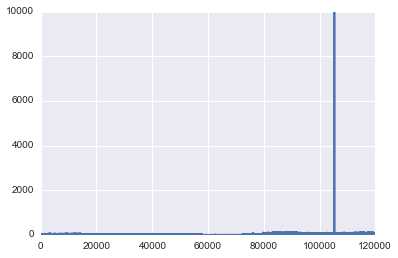

In [6]:
plt.plot(load_data.kwh);

## As a pre-process step is to identify the anomalies. Measurements are tracked per hour quarter. This specific dataset is for a house so Zero, Negative and Extremely High measurements are not sensibly and are due to meter failure. All these situations have to be identified and handled


In [7]:
load_data.kwh.describe()

count    119424.000000
mean         27.167174
std          63.328229
min           0.000000
25%           4.400000
50%          17.200000
75%          46.400000
max       10000.000000
Name: kwh, dtype: float64

In [8]:
load_data.kwh[(load_data.kwh>0.0) & (load_data.kwh!=10000)].describe() 

count    111382.000000
mean         28.769573
std          25.930861
min           0.200000
25%           6.400000
50%          19.200000
75%          49.000000
max         131.800000
Name: kwh, dtype: float64

###### Because every measurements counts, we choose not to simply remove the previous measurements but assign them a sensible value. 
##### Zero measurements will be set to the min  value of load consumption of the previous Series
##### Extremely high vill be set to the measurement of the last valid measurement 
##### Negative measurements will be set to the multiplied by -1

In [9]:
load_data.kwh[load_data.kwh==0.0] = min(load_data.kwh[(load_data.kwh>0.0) & (load_data.kwh!=10000)])
load_data.kwh[load_data.kwh<0.0] = load_data.kwh[load_data.kwh<0.0] * (-1)

In [10]:
load_data.kwh[load_data.kwh==10000.0]

88892    10000
88893    10000
88894    10000
88895    10000
Name: kwh, dtype: float64

In [11]:
load_data.ix[load_data.kwh[load_data.kwh==10000.0].index] = load_data.kwh.ix[load_data.kwh[load_data.kwh==10000.0].index[0]-1]

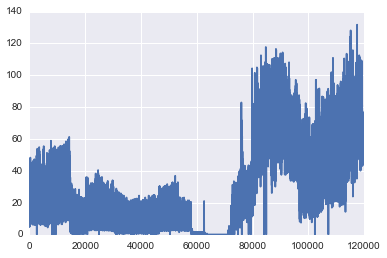

In [12]:
plt.plot(load_data.kwh);

###  The scope of this process is to predict the next day load consumption. Each day has 96 measurements so we have to aggregate the data for days. Groupby as a function is not helpful in this situation, we do not just to find out the sum of each. As we only have two dimensions (time & consumption) featyre engineering is vital. We make calculations inside the 96 measurements for each day such as std, max, min,  mean, Number of values that exceed the mean, sum, standarized sum(x - mean / std). Finally in order to predict the next's day consumption we use only the days until the prelast day. To put it briefly it a common situation in electricity utilities that they want the prediction of the next day, today. For instance if we want to predict Saturday and today is Friday we can only use the days until Thursday. So every day in the resulted dataframe has the calculations of the previous day.

In [13]:
# For some reason if a have the for loop for the len(load_data) the loop does not work. So I assign the load_data as x 
x = load_data[:load_data.shape[0]]
############### Calculate the sum of kwh for every 96 measurements (each day has 96 measurements)
p = 0
j = 1
y = []
yy = []
yy1 = []
yy2 = []
yy3 = []
yy4 = []
yy5 = []
yy6 = []
for i in range(0,len(x),96):
    y.append(sum(x['kwh'][p*96:j*96]))
    yy.append(x['Time'][p*96])
    yy1.append(np.mean(x['kwh'][p*96:j*96]))
    yy2.append(np.std(x['kwh'][p*96:j*96]))
    yy3.append(max(x['kwh'][p*96:j*96]))
    w2 = x['kwh'][p*96:j*96]
    yy4.append(float(len(w2[w2>w2.mean()])))# / len(w2))
    yy5.append((np.ptp(x['kwh'][p*96:j*96])))
    w3 = x['kwh'][p*96:j*96]
    w4 = w3.map(lambda x: abs(x-np.mean(w3)))
    yy6.append(sum(w4))
    p += 1
    j += 1

In [14]:
dd = pd.DataFrame([y,yy, yy1, yy2, yy3, yy4, yy5, yy6]).T
data = dd.sort([1])
data.head()
data.columns = ['kwh', 'Time','mean_day', 'std_day','max_day', '#values_exceed_mean', 'max-min', 'standarized_sum']

In [15]:
data.head(7)

,kwh,Time,mean_day,std_day,max_day,#values_exceed_mean,max-min,standarized_sum
191,787.2,2012-01-01 00:00:00,8.2,5.73069,23.8,44,22,478.8
202,469,2012-01-02 00:00:00,4.88542,4.50784,16.6,35,16,380.821
207,818,2012-01-03 00:00:00,8.52083,5.76733,22,46,20,493.283
201,765.6,2012-01-04 00:00:00,7.975,5.71447,22,41,20.2,494.05
190,674.6,2012-01-05 00:00:00,7.02708,5.37546,20,36,18.6,455.25
196,479.4,2012-01-06 00:00:00,4.99375,4.63074,17.2,35,16.4,389.638
209,474.2,2012-01-07 00:00:00,4.93958,4.43331,16.4,33,15.6,377.587


In [16]:
data['hour'] = data['Time'].map(lambda x: x.hour)
data['day'] = data['Time'].map(lambda x: x.day)
data['weekday'] = data['Time'].map(lambda x: x.weekday())
data['month'] = data['Time'].map(lambda x: x.month)
data['quarter'] = data['Time'].map(lambda x: x.quarter)
data['year'] = data['Time'].map(lambda x: x.year)
daily_data = data.drop(['Time','hour'],axis=1)

In [17]:
daily_data[['mean_day', 'std_day', 'max_day', '#values_exceed_mean','max-min', 'standarized_sum']]= daily_data[['mean_day', 'std_day', 'max_day', '#values_exceed_mean','max-min', 'standarized_sum']].astype(float)

In [18]:
# Reindex
daily_data.index = range(len(daily_data.kwh))
daily_data.head(7)

,kwh,mean_day,std_day,max_day,#values_exceed_mean,max-min,standarized_sum,day,weekday,month,quarter,year
0,787.2,8.200000,5.730692,23.8,44,22.0,478.800000,1,6,1,1,2012
1,469,4.885417,4.507840,16.6,35,16.0,380.820833,2,0,1,1,2012
2,818,8.520833,5.767327,22.0,46,20.0,493.283333,3,1,1,1,2012
3,765.6,7.975000,5.714474,22.0,41,20.2,494.050000,4,2,1,1,2012
4,674.6,7.027083,5.375455,20.0,36,18.6,455.250000,5,3,1,1,2012
5,479.4,4.993750,4.630735,17.2,35,16.4,389.637500,6,4,1,1,2012
6,474.2,4.939583,4.433313,16.4,33,15.6,377.587500,7,5,1,1,2012


In [19]:
X = daily_data.drop(['kwh'],axis=1)
y= daily_data['kwh']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [21]:
start_time = time.time()
param_grid = {'learning_rate': [0.07, 0.01, 0.08, 0.02, 0.03, 0.04, 0.05, 0.055, 0.045, 0.035],
              'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
              'n_estimators': [9000, 8000, 10000, 8500, 9500, 10500, 7500],
              'max_features': [2, 3, 4, 5, 6,7, 8, 9, 10, 11],
              'min_samples_leaf':[2, 3, 4, 5, 6,7, 8, 9, 10, 11],
              'subsample':[0.1, 0.2, 0.09, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#               'min_samples_split':[2, 3, 4, 5, 6]
              }
#  scoring=sklearn.metrics.make_scorer(mean_squared_error),
est = GradientBoostingRegressor(verbose=1)
# this may take some minutes
gs_cv = RandomizedSearchCV(est, param_grid, cv=5, n_jobs=1).fit(X_train, y_train)

# best hyperparameter setting
print('Best hyperparameters: %r' % gs_cv.best_params_)
est.set_params(**gs_cv.best_params_)
est.fit(X_train, y_train)
print ("--- %s seconds ---" % (time.time() - start_time))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1     5254803.1565      787535.0234            9.18s
         2     4534745.3508      659268.4111            7.29s
         3     3692957.5693      593564.7768            6.65s
         4     3133515.3835      525231.8921            6.31s
         5     2624051.7237      468892.8838            6.06s
         6     2381605.1565      348121.3291            5.89s
         7     1946040.6967      340968.2131            5.81s
         8     1742035.0090      264585.6580            5.72s
         9     1496038.1049      228112.9480            5.67s
        10     1266235.1548      192071.3089            5.61s
        20      280111.7204       47285.6542            5.88s
        30       74259.7803        9386.1518            5.56s
        40       22232.4448        2394.2950            5.39s
        50        8467.1782         535.9458            5.28s
        60        5753.9214         165.2749            5.20s
       

In [22]:
print np.mean(abs(y_test-est.predict(X_test))/y_test)

0.0281346984577


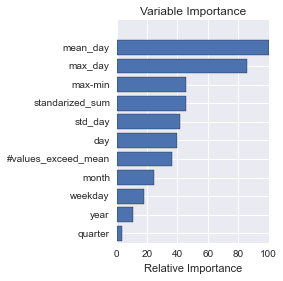

In [23]:
feature_importance = est.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

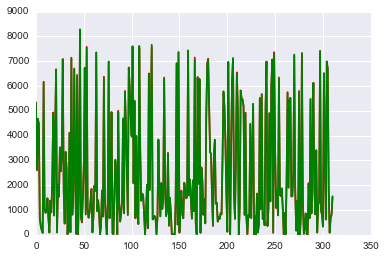

In [24]:
plt.plot(y_test.values, 'r')
plt.plot(est.predict(X_test), 'g')
plt.show()

##  We see the plot predicted vs true_values achieves the perfect match!!!